# Travelling Salesman Problem Visualization


In [1]:
import random
import math
import timeit
import os
from itertools import permutations

import numpy
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import networkx as nx
import networkx.algorithms.approximation as nx_app
import imageio
from IPython.display import Video

numpy.random.seed(2333)
random.seed(2333)


In [2]:
class TSP:

    def __init__(self, G):
        self.G = G
        self.pos = nx.get_node_attributes(self.G, "pos")
        self.G_ad = nx.to_numpy_array(self.G)
        self.mst = self.prim_algo()

    def visualize(self, edges=[], length=0):
        plt.figure(figsize=(24, 24), dpi=32, frameon=True)
        plt.autoscale(enable=False)
        if length:
            plt.title(f"Path length: {length}", fontsize = 36)
        nx.draw_networkx(
            G=self.G,
            pos=self.pos,
            edgelist=edges,
            node_size=2400,
            font_size=24,
            width=4,
            font_color='white',
            node_color='black',
            font_weight='bold',
            edge_color='blue',
        )

    def brute_force(self):
        travelNodes = {i for i in self.G.nodes()}
        travelNodes.remove(0)  # Start at node 0

        minLength = 2**63-1
        minPath = []
        pathHistory = []
        lengthHistory = []

        routePermutations = permutations(travelNodes)
        for route in routePermutations:

            length = 0

            currentNode = 0
            for node in route:
                length += self.G_ad[currentNode][node]
                currentNode = node
            length += self.G_ad[currentNode][0]

            if length < minLength:
                minLength = length
                path = ([0]+list(route)+[0])
                minPath = path
                pathHistory.append(path.copy())
                lengthHistory.append(length.copy())

        return minLength, minPath, lengthHistory, pathHistory

    def nearest_neighbour(self, startNode=None):
        travelNodes = {i for i in self.G.nodes()}
        if not startNode:
            startNode = random.choice(tuple(travelNodes))
        travelNodes.remove(startNode)  # Random startNode

        minPath = [startNode]
        minLength = 0
        currentNode = startNode
        pathHistory = [[startNode]]
        lengthHistory = [0]

        while len(travelNodes) > 0:

            next_node = None
            distance = 2**63-1

            for node in travelNodes:
                pathHistory.append(minPath+[node])
                lengthHistory.append(self.G_ad[currentNode][node]+minLength)
                if self.G_ad[currentNode][node] < distance:
                    distance = self.G_ad[currentNode][node]
                    next_node = node

            minLength += distance
            minPath.append(next_node)
            travelNodes.remove(next_node)
            currentNode = next_node

        minLength += self.G_ad[minPath[-1]][startNode]
        minPath.append(startNode)
        pathHistory.append(minPath.copy())
        lengthHistory.append(minLength)

        return minLength, minPath, lengthHistory, pathHistory

    def christofides(self):
        L = self.G.copy()
        L.remove_nodes_from([v for v, degree in self.mst.degree if not (degree % 2)])
        MG = nx.MultiGraph()
        MG.add_edges_from(self.mst.edges)
        edges = nx.min_weight_matching(L, maxcardinality=True, weight="weight")
        MG.add_edges_from(edges)
        e_circuit = [n for n in nx.eulerian_circuit(MG)]
        path = self.remove_repeated_in_circuit(e_circuit)
        length = 0 
        for i, j in path_to_edgelist(path):
            length += math.hypot(self.pos[i][0] - self.pos[j][0], self.pos[i][1] - self.pos[j][1])
        return length, path

    def prim_algo(self):
        visited = [0]
        edge_list = []
        while len(visited) < len(self.G_ad):
            distance = 2**63-1
            next_edge = (0, 0)

            for n in visited:
                for i, v in enumerate(self.G_ad[n]):
                    if i not in visited:
                        if v < distance:
                            distance = v
                            next_edge = (n, i)

            edge_list.append(next_edge)
            visited.append(next_edge[1])
        self.update_mst(edge_list)
        return edge_list

    def krusal_algo(self):
        '''
        [TODO] This implementation is garbage. DFS is too slow. Fix later.
        '''
        def check_cycle(tree, node, parent, visited):
            visited.append(node)
            for n in tree.neighbors(node):
                if n not in visited:
                    if check_cycle(tree, n, node, visited):
                        return True
                elif n != parent:
                    return True
            return False

        sorted_edges = sorted(self.G.edges(data=True),
                              key=lambda t: t[2].get('weight', 1))
        tree = nx.Graph()

        for n1, n2, _ in sorted_edges:
            tree.add_edge(n1, n2)
            for n in list(tree.nodes()):
                visited = list()
                if check_cycle(tree, n, n, visited):
                    tree.remove_edge(n1, n2)
        edge_list = tree.edges
        self.update_mst(edge_list)
        return edge_list
    
    def update_mst(self, edge_list):
        mst = nx.create_empty_copy(self.G)
        for i, j in edge_list:
            dist = math.hypot(
                self.pos[i][0] - self.pos[j][0], self.pos[i][1] - self.pos[j][1])
            mst.add_edge(i, j, weight=dist)
        self.mst = mst


    def remove_repeated_in_circuit(self, circuit):
        path = []
        for u, v in circuit:
            if v in path:
                continue
            if not path:
                path.append(u)
            path.append(v)
        path.append(path[0])
        return path

    def gen_animation(self, lengthHistory, pathHistory, name):
        if not os.path.exists(f'{name}/images'):
            os.makedirs(f'{name}/images')

        with imageio.get_writer(f'{name}/{name}.gif', mode='I', duration=0.2) as writer:
            for i in range(len(lengthHistory)):
                self.visualize(path_to_edgelist(pathHistory[i]), lengthHistory[i])
                plt.savefig(f'{name}/images/{i}')
                plt.close()
                writer.append_data(imageio.imread(f'{name}/images/{i}.png'))
            for _ in range(5):
                writer.append_data(imageio.imread(
                    f'{name}/images/{len(lengthHistory)-1}.png'))

        images = []
        for i in range(len(lengthHistory)):
            self.visualize(path_to_edgelist(pathHistory[i]), lengthHistory[i])
            plt.savefig(f'{name}/images/{i}')
            plt.close()
            images.append(imageio.imread(f'{name}/images/{i}.png'))
        for _ in range(5):
            images.append(imageio.imread(
                f'{name}/images/{len(lengthHistory)-1}.png'))
        imageio.mimsave(f'{name}/{name}.mp4', images)


In [3]:
def gen_tsp_graph(size):
    G = nx.random_geometric_graph(size, 0.2)
    pos = nx.get_node_attributes(G, "pos")
    for i in range(len(pos)):
        for j in range(i + 1, len(pos)):
            dist = math.hypot(
                pos[i][0] - pos[j][0], pos[i][1] - pos[j][1])
            G.add_edge(i, j, weight=dist)
    return G


def path_to_edgelist(path):
    return list(nx.utils.pairwise(path))


## Initial Setup


In [4]:
G = gen_tsp_graph(size=9)
tsp = TSP(G)


## Brute Force


In [5]:
minLength, minPath, lengthHistory, pathHistory = tsp.brute_force()
tsp.gen_animation(lengthHistory, pathHistory, 'brute_force')
print(minLength, minPath)


2.961390392943015 [0, 3, 6, 7, 8, 5, 1, 2, 4, 0]


In [6]:
Video('brute_force/brute_force.mp4')


## Nearest Neighbour


In [7]:
minLength, minPath, lengthHistory, pathHistory = tsp.nearest_neighbour()
tsp.gen_animation(lengthHistory, pathHistory, 'nearest_neighbour')
print(minLength, minPath)


3.162652622005056 [3, 0, 7, 8, 5, 1, 2, 4, 6, 3]


In [8]:
Video('nearest_neighbour/nearest_neighbour.mp4')


## Christofides Approximation


### Minimal Spanning Tree


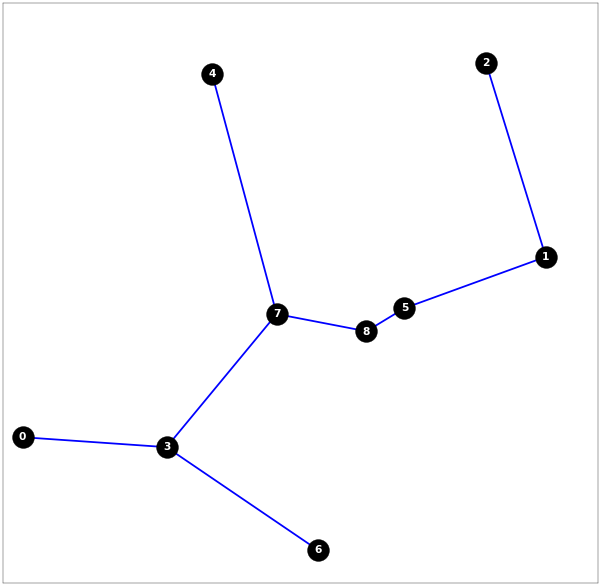

In [9]:
tsp.visualize(tsp.prim_algo())


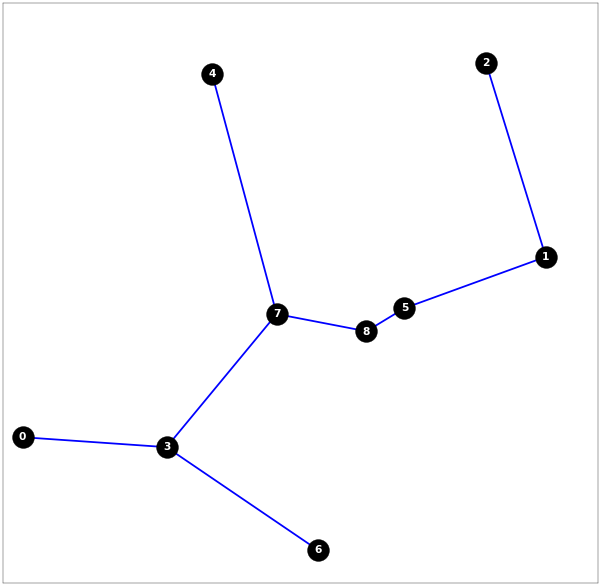

In [10]:
tsp.visualize(tsp.krusal_algo())


2.961390392943015 [0, 3, 6, 7, 8, 5, 1, 2, 4, 0]


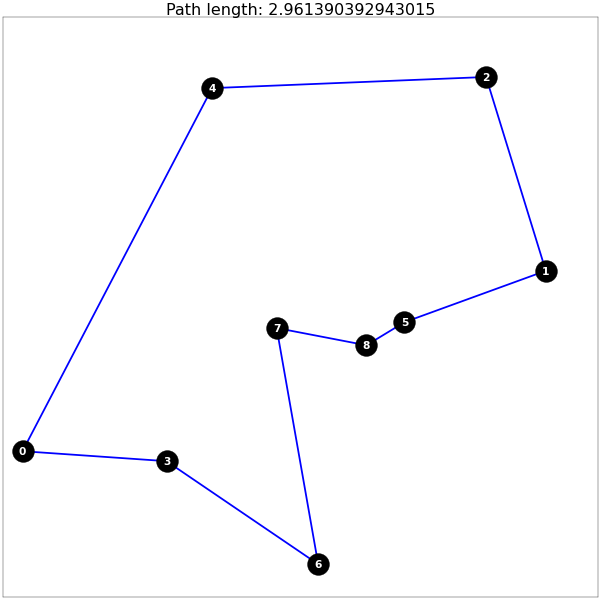

In [13]:
length, path = tsp.christofides()
print(length, path)
tsp.visualize(path_to_edgelist(path), length=length)

## Runtime Comparison


In [ ]:
bf = []
nn = []
ch = []

for i in range(2, 13):
    G = gen_tsp_graph(size=i)
    tsp = TSP(G)

    start = timeit.default_timer()
    tsp.brute_force()
    end = timeit.default_timer()
    bf.append(end-start)

    start = timeit.default_timer()
    tsp.nearest_neighbour()
    end = timeit.default_timer()
    nn.append(end-start)

    start = timeit.default_timer()
    nx_app.christofides(G, weight="weight")
    end = timeit.default_timer()
    ch.append(end-start)


In [ ]:
data = {
    'Brute Force': bf,
    'Nearest Neighbours': nn,
    'Christofides': ch,
}
df = pd.DataFrame(data, index=[i for i in range(2, 13)])


In [ ]:
fig = px.line(df, title="Runtime Comparison for 2-12 Cities")
fig.update_xaxes(title="Amount of Cities")
fig.update_yaxes(title="Execution Time (s)")
fig.show()


In [ ]:
nn = []
ch = []

for i in range(10, 501, 10):
    G = gen_tsp_graph(size=i)
    tsp = TSP(G)

    start = timeit.default_timer()
    tsp.nearest_neighbour()
    end = timeit.default_timer()
    nn.append(end-start)

    start = timeit.default_timer()
    nx_app.christofides(G, weight="weight")
    end = timeit.default_timer()
    ch.append(end-start)


In [ ]:
data = {
    'Nearest Neighbours': nn,
    'Christofides': ch,
}
df = pd.DataFrame(data, index=[i for i in range(10, 501, 10)])
df.head()


,Nearest Neighbours,Christofides
10,0.000049,0.000986
20,0.000121,0.002630
30,0.000266,0.002745
40,0.000496,0.007005
50,0.000724,0.009827


In [ ]:
fig = px.line(df, title="Runtime Comparison for 10-500 Cities")
fig.update_xaxes(title="Amount of Cities")
fig.update_yaxes(title="Execution Time (s)")
fig.show()
